In [2]:
# !wget https://storage.googleapis.com/chesspic/datasets/2021-07-31-lichess-evaluations-37MM.db.gz
!gzip -fdk "2021-07-31-lichess-evaluations-37MM.db.gz"
#!rm "2021-07-31-lichess-evaluations-37MM.db.gz"

In [8]:
!pip install peewee pytorch-lightning
!pip install torchsummary torchinfo

In [9]:
from peewee import *
import base64

db = SqliteDatabase('2021-07-31-lichess-evaluations-37MM.db')

class Evaluations(Model):
    id = IntegerField()
    fen = TextField()
    binary = BlobField()
    eval = FloatField()

    class Meta:
        database = db

    def binary_base64(self):
        return base64.b64encode(self.binary)
    
db.connect()
LABEL_COUNT = 37_164_639
# LABEL_COUNT = 1000000
print(LABEL_COUNT)
eval = Evaluations.get(Evaluations.id == 1)
print(eval.binary_base64())

37164639
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='


In [10]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
import pytorch_lightning as pl
from random import randrange
import time
from collections import OrderedDict

class EvaluationDataset(IterableDataset):
    def __init__(self, count):
        self.count = count
    def __iter__(self):
        return self
    def __next__(self):
        idx = randrange(self.count)
        return self[idx]
    def __len__(self):
        return self.count
    def __getitem__(self, idx):
        eval = Evaluations.get(Evaluations.id == idx+1)
        bin = np.frombuffer(eval.binary, dtype=np.uint8)
        bin = np.unpackbits(bin, axis=0).astype(np.single) 
        eval.eval = max(eval.eval, -15)
        eval.eval = min(eval.eval, 15)
        ev = np.array([eval.eval]).astype(np.single) 
        return {'binary':bin, 'eval':ev}    

dataset = EvaluationDataset(count=LABEL_COUNT)

In [6]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [11]:
import time
from collections import OrderedDict

class EvaluationModel(pl.LightningModule):
    def __init__(self,learning_rate=1e-3,batch_size=1024,layer_count=10):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        layers = []
        for i in range(layer_count-1):
            layers.append((f"linear-{i}", nn.Linear(808, 808)))
            layers.append((f"relu-{i}", nn.ReLU()))
        layers.append((f"linear-{layer_count-1}", nn.Linear(808, 1)))
        self.seq = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.seq(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['binary'], batch['eval']
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        dataset = EvaluationDataset(count=LABEL_COUNT)
        return DataLoader(dataset, batch_size=self.batch_size, num_workers=2, pin_memory=True)

# configs = [
#           #  {"layer_count": 4, "batch_size": 64},
#           #  {"layer_count": 4, "batch_size": 512},
#            {"layer_count": 6, "batch_size": 1024},
#            ]
# for config in configs:
#   version_name = f'{int(time.time())}-batch_size-{config["batch_size"]}-layer_count-{config["layer_count"]}'
#   logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
#   trainer = pl.Trainer(precision=16,max_epochs=1,auto_lr_find=True,logger=logger)
#   model = EvaluationModel(layer_count=config["layer_count"],batch_size=config["batch_size"],learning_rate=1e-3)
#   # trainer.tune(model)
#   # lr_finder = trainer.tuner.lr_find(model, min_lr=1e-6, max_lr=1e-3, num_training=25)
#   # fig = lr_finder.plot(suggest=True)
#   # fig.show()
#   trainer.fit(model)
#   break

In [12]:
# load trained model
model = torch.load("chessAiModel")


In [13]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
EvaluationModel                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       653,672
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       653,672
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       653,672
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       653,672
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       653,672
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      809
Total params: 3,269,169
Trainable params: 3,269,169
Non-trainable params: 0

Idx 12895875 Eval -0.83 Prediction -0.10 Loss 0.73
FEN 8/6k1/p2pp3/1pp3pp/2Pb4/1P1P1P1K/P7/5R2 b - - 3 34


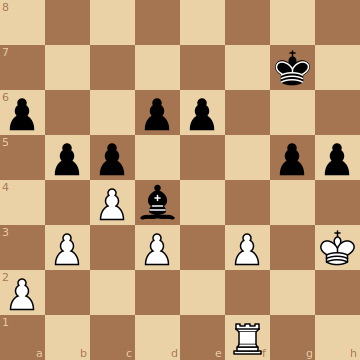

Idx 27404266 Eval -15.00 Prediction -11.91 Loss 3.09
FEN 8/5R2/8/3p4/3r4/8/PPK1pk2/8 b - - 3 45


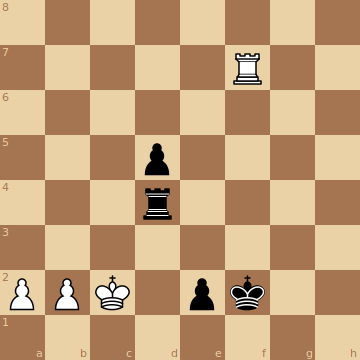

Idx 35448721 Eval -0.96 Prediction -1.48 Loss 0.52
FEN r1bqkr2/pp4pp/5p2/P2pp3/2P2n2/5N2/P2P1PPP/RN1Q1RK1 w q d6 0 12


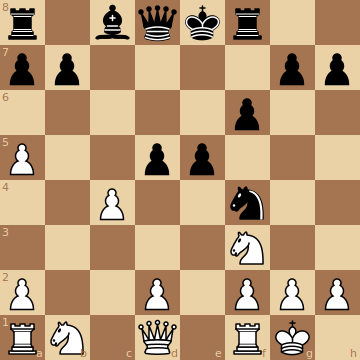

Idx 9747570 Eval 0.25 Prediction 0.16 Loss 0.09
FEN r2qkb1r/pb3ppp/1pnppn2/2p5/2B1PB2/2NP1N2/PPP2PPP/R2Q1RK1 w kq - 1 8


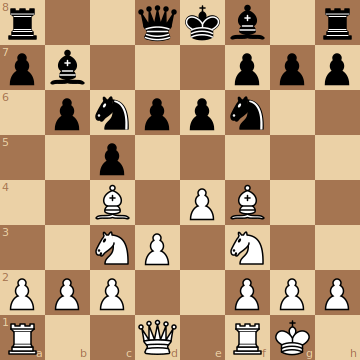

Idx 11905955 Eval -15.00 Prediction -14.87 Loss 0.13
FEN 8/8/8/PK6/2p1p3/2k5/8/5q2 b - - 0 45


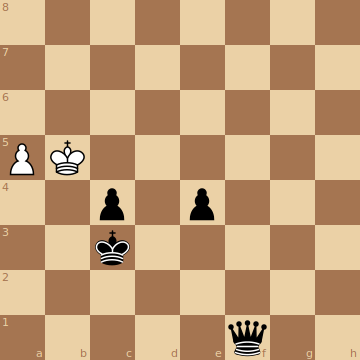

In [14]:
from IPython.display import display, SVG
from random import randrange

SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/" 

def svg_url(fen):
  fen_board = fen.split()[0]
  return SVG_BASE_URL + fen_board

def show_index(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  display(SVG(url=svg_url(eval.fen)))

for i in range(5):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

# need to do better on "tactics" like 700756

In [15]:
import chess

MATERIAL_LOOKUP = {chess.KING:0,chess.QUEEN:9,chess.ROOK:5,chess.BISHOP:3,chess.KNIGHT:3,chess.PAWN:1}

def avg(lst):
    return sum(lst) / len(lst)

def material_for_board(board):
    eval = 0.0
    for sq, piece in board.piece_map().items():
        mat = MATERIAL_LOOKUP[piece.piece_type] 
        if piece.color == chess.BLACK:
            mat = mat * -1
        eval += mat
    return eval
  
def guess_zero_loss(idx):
    eval = Evaluations.select().where(Evaluations.id == idx+1).get()
    y = torch.tensor(eval.eval)
    y_hat = torch.zeros_like(y)
    loss = F.l1_loss(y_hat, y)
    return loss

def guess_material_loss(idx):
    eval = Evaluations.select().where(Evaluations.id == idx+1).get()
    board = chess.Board(eval.fen)
    y = torch.tensor(eval.eval)
    y_hat = torch.tensor(material_for_board(board))
    loss = F.l1_loss(y_hat, y)
    return loss

def guess_model_loss(idx):
    eval = Evaluations.select().where(Evaluations.id == idx+1).get()
    batch = dataset[idx]
    x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
    y_hat = model(x)
    loss = F.l1_loss(y_hat, y)
    return loss

zero_losses = []
mat_losses = []
model_losses = []
for i in range(1000):
    idx = randrange(LABEL_COUNT)
    zero_losses.append(guess_zero_loss(idx))
    mat_losses.append(guess_material_loss(idx))
    model_losses.append(guess_model_loss(idx))
print(f'Guess Zero Avg Loss {avg(zero_losses)}')
print(f'Guess Material Avg Loss {avg(mat_losses)}')
print(f'Guess Model Avg Loss {avg(model_losses)}')

Guess Zero Avg Loss 7.177585124969482
Guess Material Avg Loss 4.970786094665527
Guess Model Avg Loss 1.6524488925933838


In [16]:
eval1 = Evaluations.select().where(Evaluations.id == 1).get()

In [17]:
Dict = {}
for i in range(10000):   
    if Evaluations.select().where(Evaluations.id == i+ 1).get().fen.split()[2] != "-":
        Dict[Evaluations.select().where(Evaluations.id == i+ 1).get().fen.split()[2]] = dataset[i]["binary"][-4:]


In [18]:
Dict

{'KQkq': array([1., 1., 1., 1.], dtype=float32),
 'KQ': array([0., 0., 1., 1.], dtype=float32),
 'kq': array([1., 1., 0., 0.], dtype=float32),
 'KQk': array([0., 1., 1., 1.], dtype=float32),
 'k': array([0., 1., 0., 0.], dtype=float32),
 'q': array([1., 0., 0., 0.], dtype=float32),
 'Qkq': array([1., 1., 1., 0.], dtype=float32),
 'Qq': array([1., 0., 1., 0.], dtype=float32),
 'Q': array([0., 0., 1., 0.], dtype=float32),
 'K': array([0., 0., 0., 1.], dtype=float32),
 'Kkq': array([1., 1., 0., 1.], dtype=float32),
 'KQq': array([1., 0., 1., 1.], dtype=float32)}

In [19]:
for i in range(371646):
    if 1. in dataset[i]["binary"][-4*8:-3*8]:
        print(i, dataset[i]["binary"][-4*8:-3*8])

In [65]:
def bitboard(board):
    w_pawn = (np.asarray(board.pieces(chess.PAWN, chess.WHITE).tolist())).astype(int)
    w_rook = (np.asarray(board.pieces(chess.ROOK, chess.WHITE).tolist())).astype(int)
    w_knight = (np.asarray(board.pieces(chess.KNIGHT, chess.WHITE).tolist())).astype(int)
    w_bishop = (np.asarray(board.pieces(chess.BISHOP, chess.WHITE).tolist())).astype(int)
    w_queen = (np.asarray(board.pieces(chess.QUEEN, chess.WHITE).tolist())).astype(int)
    w_king = (np.asarray(board.pieces(chess.KING, chess.WHITE).tolist())).astype(int)

    b_pawn = (np.asarray(board.pieces(chess.PAWN, chess.BLACK).tolist())).astype(int)
    b_rook = (np.asarray(board.pieces(chess.ROOK, chess.BLACK).tolist())).astype(int)
    b_knight = (np.asarray(board.pieces(chess.KNIGHT, chess.BLACK).tolist())).astype(int)
    b_bishop = (np.asarray(board.pieces(chess.BISHOP, chess.BLACK).tolist())).astype(int)
    b_queen = (np.asarray(board.pieces(chess.QUEEN, chess.BLACK).tolist())).astype(int)
    b_king = (np.asarray(board.pieces(chess.KING, chess.BLACK).tolist())).astype(int)
    
    testFen = board.fen(en_passant="fen")
#     print(testFen)
    bit12WhoToMove = 1 if testFen.split()[1] == "b" else 0
    numericLetter = -1
    rankNumber = 0
    if '-' not in testFen.split()[3]:
        numericLetter = ord(testFen.split()[3][0]) - ord('a')
        rankNumber = int(testFen.split()[3][1]) - 1
    
    isEnPassant = 0 if testFen.split()[3][0] == '-' else 1
    castlingStr = testFen.split()[2]
    castling = ((1<<3) if "q" in castlingStr else 0) + ((1<<2) if "k" in castlingStr else 0)\
             + ((1<<1) if "Q" in castlingStr else 0) + (1 if "K" in castlingStr else 0)
    
    firstInt = int(testFen.split()[-2])
    secondInt = 0
    thirdInt = int(testFen.split()[-1])
    forthInt = (rankNumber << 3) + numericLetter
    fifthInt = (isEnPassant << 5) + (bit12WhoToMove << 4) + castling
    
    add_info = np.array([firstInt, secondInt, thirdInt, forthInt, fifthInt], dtype=np.uint8)
    add_info = np.unpackbits(add_info, axis=0).astype(np.single) 

    customBitboard = np.concatenate((w_king, w_queen, w_rook, w_bishop, w_knight, w_pawn,
                                     b_king, b_queen, b_rook, b_bishop, b_knight, b_pawn,
                                     add_info))
    
#     print(customBitboard)
    return customBitboard

In [21]:
def testBitboard(idx):
    eval1 = Evaluations.select().where(Evaluations.id == idx + 1).get()
    board = chess.Board(eval1.fen)
    board.set_fen(eval1.fen)
    myBitboard = bitboard(board)
    if False in (dataset[idx]["binary"] == myBitboard):
        print(idx, dataset[idx]["binary"] == myBitboard)
        print(myBitboard[-16:])
        print(dataset[idx]["binary"][-16:])
        print(eval1.fen)
    
testBitboard(1)

rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBNR w KQkq d6 0 2


In [22]:
for i in range(2):
    testBitboard(i)

rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq d3 0 1
rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBNR w KQkq d6 0 2


In [50]:
def positionScore(fen):
    target_bitboard = bitboard(chess.Board(fen))
    x = torch.tensor(target_bitboard).float()
    y_hat = model(x)
    print(f'FEN {fen}')
    print(f'Prediction {y_hat.data[0]:.2f}')
    display(SVG(url=svg_url(fen)))
    

In [93]:
def boardScore(board):
    target_bitboard = bitboard(board)
    x = torch.tensor(target_bitboard).float()
    y_hat = model(x)
#     print(f'FEN {board.fen(en_passant="fen")}')
#     print(f'Prediction {y_hat.data[0]:.2f}')
    return y_hat.data[0]
#     display(SVG(url=svg_url(fen)))

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
Idx 23617549 Prediction 0.43
FEN rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


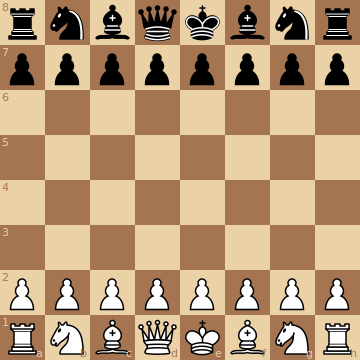

rnbqkbnr/pppppppp/8/8/8/8/5PPP/5RK1 w kq - 0 1
Idx 23617549 Prediction -14.88
FEN rnbqkbnr/pppppppp/8/8/8/8/5PPP/5RK1 w kq - 0 1


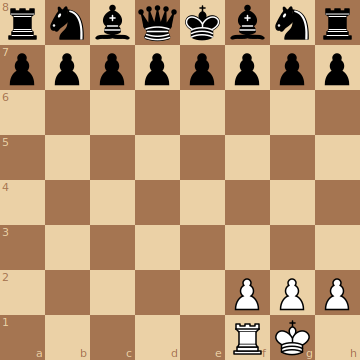

In [24]:
positionScore("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")    
positionScore('rnbqkbnr/pppppppp/8/8/8/8/5PPP/5RK1 w kq - 0 1')

In [ ]:
def show_index(idx):
    eval = Evaluations.select().where(Evaluations.id == idx+1).get()
    batch = dataset[idx]
    x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
    y_hat = model(x)
    loss = F.l1_loss(y_hat, y)
    print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
    print(f'FEN {eval.fen}')
    display(SVG(url=svg_url(eval.fen)))
    
    
    eval = Evaluations.select().where(Evaluations.id == idx+1).get()
    batch = dataset[idx]
    x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])

In [103]:
def find_best_move(board, depth=1):
    legal_moves = list(board.legal_moves)
    print("count of possible moves:", len(legal_moves))
    moves_eval = {}

    for move in legal_moves:
        board.push(move)
        find_best_move(board, 0)
        moves_eval[move] = boardScore(board)
        print(f'{move} -> {moves_eval[move]:.2f}')
        board.pop()
        
    if chess.WHITE == board.turn:
        best_move = max(moves_eval, key=moves_eval.get)
    else:
        best_move = min(moves_eval, key=moves_eval.get)
    print(f'best move: {best_move}, eval: {moves_eval[best_move]}')
    return best_move

In [70]:
start_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board = chess.Board(start_fen)

In [76]:
board.push_san("e6")

Move.from_uci('e7e6')

In [104]:
best_move = find_best_move(board)
board.push(best_move)
print(board)
print(board.fen(en_passant="fen"))

count of possible moves: 41
c3d5 -> 6.91
c3b5 -> 1.65
c3a4 -> 1.11
c3e2 -> 1.40
c3b1 -> 1.20
g1h3 -> 3.30
g1f3 -> 3.21
g1e2 -> 3.13
f1d3 -> 2.80
f1e2 -> 2.78
e1e2 -> 1.67
e1d2 -> 1.11
d1h5 -> 2.33
d1g4 -> 2.07
d1a4 -> 2.38
d1f3 -> 2.57
d1d3 -> 2.32
d1b3 -> 2.78
d1e2 -> 2.67
d1d2 -> 2.62
d1c2 -> 2.48
c1h6 -> 2.62
c1g5 -> 2.94
c1f4 -> 3.26
c1e3 -> 3.20
c1d2 -> 2.95
a1b1 -> 2.92
e4d5 -> 7.75
c4d5 -> 8.29
e4e5 -> 1.94
c4c5 -> 1.74
h2h3 -> 2.82
g2g3 -> 2.92
f2f3 -> 2.55
b2b3 -> 2.61
a2a3 -> 2.84
h2h4 -> 3.41
g2g4 -> 2.85
f2f4 -> 2.40
b2b4 -> 2.48
a2a4 -> 2.29
best move: c4d5, eval: 8.286725997924805
r n . q k b n r
p . p p . p p p
. p . . p . . .
. . . P . . . .
. . . P P . . .
. . N . . . . .
P P . . . P P P
R . B Q K B N R
rn1qkbnr/p1pp1ppp/1p2p3/3P4/3PP3/2N5/PP3PPP/R1BQKBNR b KQkq - 0 5


In [110]:
def play_game():
#     start_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
    start_fen = "8/3R4/1K6/p5k1/P1P5/8/8/8 b - - 8 130"
    board = chess.Board(start_fen)
    
    player_move = input()
    board.push_san(player_move)
    
    while True:
        best_move = find_best_move(board)
        board.push(best_move)
        print(board)
        print(board.fen(en_passant="fen"))
        player_move = input()
        board.push_san(player_move)

In [ ]:
play_game()

Kh5
count of possible moves: 23
d7d8 -> 14.97
d7h7 -> 14.99
d7g7 -> 15.05
d7f7 -> 14.98
d7e7 -> 15.03
d7c7 -> 15.06
d7b7 -> 15.07
d7a7 -> 15.07
d7d6 -> 14.99
d7d5 -> 15.02
d7d4 -> 15.04
d7d3 -> 15.06
d7d2 -> 15.04
d7d1 -> 15.04
b6c7 -> 14.98
b6b7 -> 14.98
b6a7 -> 15.07
b6c6 -> 15.05
b6a6 -> 15.05
b6c5 -> 15.02
b6b5 -> 15.00
b6a5 -> 15.03
c4c5 -> 15.01
best move: d7b7, eval: 15.072903633117676
. . . . . . . .
. R . . . . . .
. K . . . . . .
p . . . . . . k
P . P . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
8/1R6/1K6/p6k/P1P5/8/8/8 b - - 10 131
Kg5
count of possible moves: 16
b7b8 -> 14.86
b7h7 -> 14.96
b7g7 -> 14.99
b7f7 -> 15.05
b7e7 -> 15.00
b7d7 -> 15.04
b7c7 -> 14.92
b7a7 -> 14.95
b6c7 -> 15.05
b6a7 -> 14.96
b6c6 -> 14.93
b6a6 -> 14.96
b6c5 -> 14.99
b6b5 -> 14.98
b6a5 -> 15.06
c4c5 -> 15.07
best move: c4c5, eval: 15.069208145141602
. . . . . . . .
. R . . . . . .
. K . . . . . .
p . P . . . k .
P . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
8/1R6/1K6/p1

Kxc5
count of possible moves: 10
a7a8 -> 15.00
a7h7 -> 15.04
a7g7 -> 15.00
a7f7 -> 15.01
a7e7 -> 14.99
a7d7 -> 15.03
a7c7 -> 15.03
a7b7 -> 15.06
a6b7 -> 15.02
a6a5 -> 14.98
best move: a7b7, eval: 15.055252075195312
. . . . . . . .
. R . . . . . .
K . . . . . . .
p . k . . . . .
P . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
8/1R6/K7/p1k5/P7/8/8/8 b - - 1 149
Kd5
count of possible moves: 18
b7b8 -> 14.99
b7h7 -> 15.04
b7g7 -> 15.00
b7f7 -> 15.00
b7e7 -> 14.99
b7d7 -> 14.97
b7c7 -> 14.98
b7a7 -> 15.03
b7b6 -> 14.96
b7b5 -> 14.96
b7b4 -> 14.97
b7b3 -> 14.98
b7b2 -> 14.98
b7b1 -> 14.98
a6a7 -> 15.01
a6b6 -> 15.03
a6b5 -> 14.98
a6a5 -> 14.98
best move: b7h7, eval: 15.042234420776367
. . . . . . . .
. . . . . . . R
K . . . . . . .
p . . k . . . .
P . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
8/7R/K7/p2k4/P7/8/8/8 b - - 3 150
Ke4
count of possible moves: 19
h7h8 -> 15.00
h7g7 -> 15.02
h7f7 -> 15.02
h7e7 -> 14.98
h7d7 -> 15.01
h7c7 -> 15.03
h7b7 -> 15.02
h7a7

###### 